<a href="https://colab.research.google.com/github/juanserrano90/raaa67_bayes/blob/main/notebooks/2_ejercicio_51pegb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

In [2]:
!pip install exoplanet       # unicos paquetes que no están ya disponibles en el entorno de Colab
!pip install exoplanet_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.7/205.7 kB 4.0 MB/s eta 0:00:00


In [3]:
import exoplanet as xo

# Ejercicio: Modelado de velocidades radiales para detección de exoplanetas.

El 23 de Noviembre de 1995 Michel Mayor & Didier Queloz publicaron en Nature un [artículo](https://wwelsh.sdsu.edu/CLASSES/ASTR510/PAPERS/Mayor-Queloz_51Peg.pdf) anunciando la detección del exoplaneta **51 Peg b**, el primer planeta extrasolar en una estrella de secuencia principal. Lo hicieron mediante el método de velocidades radiales, con medidas espectroscópicas de alta resolución de ELODIE, ubicado en el telescopio de 1.93-m del Observatoire de Haute-Provence, en Francia.

El planeta es un **Júpiter caliente**, con una órbita de $P\approx4.2$ días y una masa mínima $M_P \sin(i) \approx 0.47 \pm 0.02 ~M_J$.

Mayor & Queloz midieron la masa y período de 51 Peg b con unas 35 observaciones de velocidad radial recolectadas en alrededor de un año, llevándolos a ganar el Premio Nobel de Física en el año 2019. Hoy en día hay muchísimas mediciones de la velocidad radial 51 Peg de distintos instrumentos más precisos que ELODIE, pero la medida de la masa  sigue siendo prácticamente [la misma](https://exoplanet.eu/catalog/51_peg_b--12/) que determinaron en 1995.

Les propongo modelar **el mismo dataset** con el que trabajaron Mayor & Queloz, pero con un enfoque Bayesiano!

El modelo es muy sencillo, tenemos una serie Vr vs t que proponemos se puede modelar con una Kepleriana debido a la presencia de un planeta.

$$
v_r(t) = \gamma + K \left[ \cos(\nu(t) + \omega) + e \cos \omega \right]
$$

donde:  
- $\gamma$ = velocidad sistémica (offset)  
- $K$ = semi–amplitud  
- $\nu(t)$ = anomalía verdadera en el tiempo $t$  
- $\omega$ = argumento del periastro  
- $e$ = excentricidad orbital  

La velocidad sistémica la podemos descartar del modelo si centramos las velocidades en cero y solo modelamos las variaciones de la Vr.

La semiamplitud de la curva es uno de los parámetros importantes, y es el que nos va a permitir derivar la masa.

**Semi–amplitud $K$**

$$
K ≈ \left( \frac{2 \pi G}{P M_\star^2} \right)^{1/3}
    \frac{M_p \sin i}{\sqrt{1 - e^2}}
$$

donde:  
- $P$ = período orbital  
- $G$ = constante de gravitación universal  
- $M_p$ = masa del planeta  
- $M_\star$ = masa de la estrella  
- $i$ = inclinación orbital  
- $e$ = excentricidad orbital  



La ecuación de la curva kepleriana requiere resolver la ecuación de Kepler para pasar de $t$ a $\nu$, pero eso lo va a hacer `exoplanet` por nosotros con la función `KeplerianOrbit` ([documentación](https://docs.exoplanet.codes/en/latest/user/api/#exoplanet.orbits.KeplerianOrbit)), solo tenemos que pasarle los parámetros que vayamos a usar para el modelo (y definir sus priors).

# 1. Carga de datos.

In [4]:
# read data from url
url = "https://raw.githubusercontent.com/juanserrano90/raaa67_bayes/refs/heads/main/data/51_peg_ELODIE_DRS-TACOS.rdb"

df = pd.read_table(url, sep='\s+', skiprows=[1])

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2946536399.py:4: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table(url, sep='\s+', skiprows=[1])


In [5]:
df.columns

Index(['rjd', 'vrad', 'svrad', 'fwhm', 'sig_fwhm', 'contrast', 'sig_contrast',
       'weight'],
      dtype='object')

In [6]:
# mask before 49990.5, para usar solo los datos que usaron Queloz&Mayor
mask = df["rjd"] < 49990.5
len(df[mask])

41

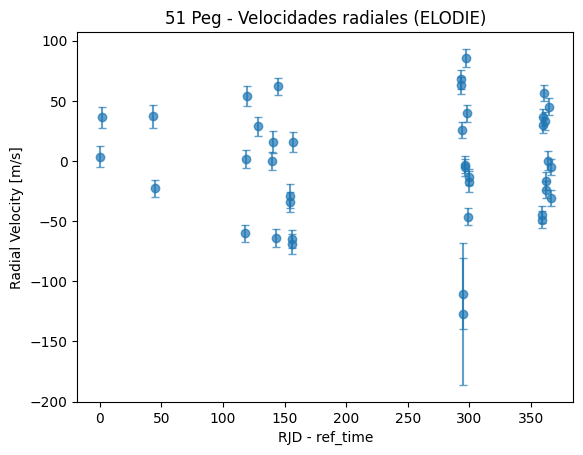

In [7]:
ref_time = df["rjd"].values[0]
t = np.ascontiguousarray(df.rjd.values[mask]-ref_time, dtype=np.float64)
y = np.ascontiguousarray(df.vrad.values[mask]-np.median(df.vrad.values[mask]), dtype=np.float64)
yerr = np.ascontiguousarray(df.svrad.values[mask], dtype=np.float64)

plt.errorbar(t, y, yerr=yerr, fmt='o', capsize=3, alpha=0.7)
plt.xlabel("RJD - ref_time")
plt.ylabel("Radial Velocity [m/s]")
plt.title("51 Peg - Velocidades radiales (ELODIE)")
plt.show()

Hagamos un periodograma para ver si detectamos la señal periódica de algún planeta...

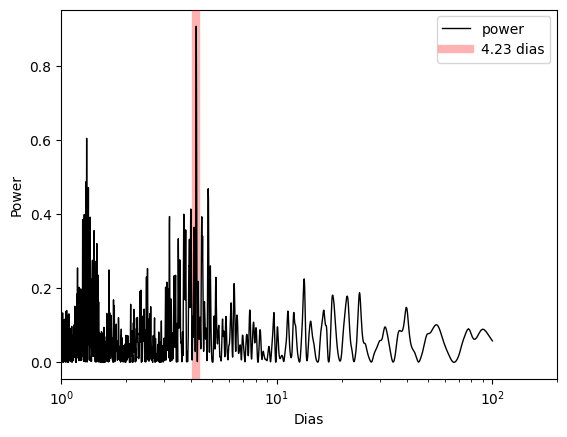

periodo de mayor potencia: 4.23 dias


In [8]:
from astropy.timeseries import LombScargle
ls = LombScargle(t, y, dy=yerr)
frequency, power = ls.autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
plt.plot(1/frequency, power, zorder=100, label='power', color='k', lw=1)
plt.xlim(1,200)
plt.axvline(4.23, color='r', lw=6, zorder=10, label=f'{4.23:.2f} dias', alpha=0.3)
plt.xscale('log')
plt.xlabel("Dias")
plt.ylabel("Power")
plt.legend()
plt.show()

# periodo detectado
tls_p = 1/frequency[np.argmax(power)]
print(f'periodo de mayor potencia: {tls_p:.2f} dias')

# 2. Modelado

El modelo más simple puede ser con los siguientes parámetros libres:
- Periodo (P)
- Semi-amplitud (K)
- Tiempo de pasaje por el periastro (t_peri)
- Offset de velocidad radial (mean)
- Jitter de velocidad radial (sigma) -> este se suma cuadraticamente a los errores de las RVs -> $RV_{err} = \sqrt{sigma^2 + yerr^2}$

In [ ]:
# Completar para construir el modelo a su gusto.

with pm.Model() as model:

    # Parámetros orbitales (priors)
    ?
    ?

    # Definimos la órbita Kepleriana
    orbit = xo.orbits.KeplerianOrbit(?)

    # Instanciada la órbita, el método siguiente nos hace las predicciones de la Vr
    rvs = orbit.get_radial_velocity(?)


    # Likelihood
    ?

# 3. Sampleo

In [ ]:
# sampling
# recomendado usar init='adapt_full' para modelos con exoplanet, e inicializar en la solucion MAP con initvals=map

with model:
    trace = pm.sample(
        ?
    )

# 4. Resultados y model check

In [ ]:
# trace
# summary